In [1]:
import pickle
path = 'dataset/pickle/v2/greedy(train_angle)/1LXtFkjw3qL/260578.pkl'

In [2]:
with open(path , 'rb') as f:
    data = pickle.load(f)

/home/getuanhui/anaconda3/envs/ss/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data.keys(
)

dict_keys(['obs', 'reward', 'done', 'action_id', 'info', 'map', 'path_point', 'sound_id'])

In [4]:
from utils.visualizations import plot_top_down_map

In [5]:
from PIL import Image

In [6]:
data['action_id']

[[3, 3, 1, 1, 1, 2, 1, 0]]

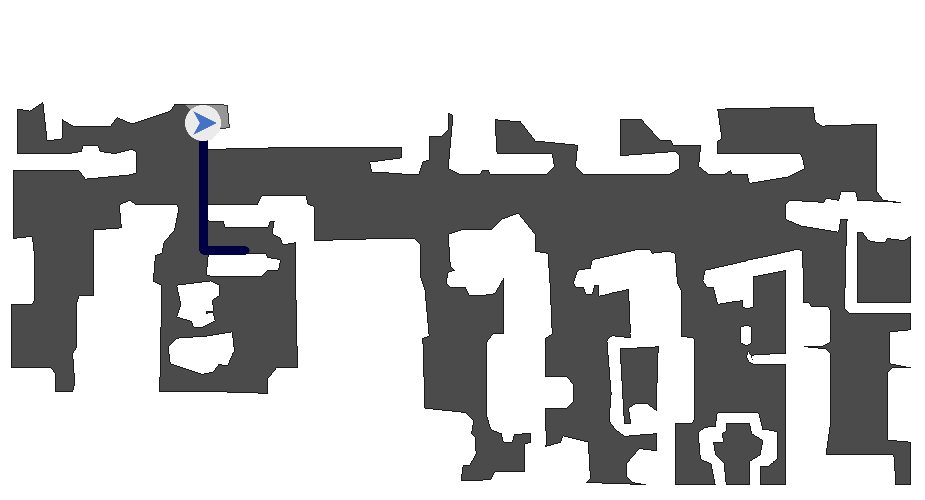

In [8]:
Image.fromarray(plot_top_down_map(data['info'][0]))

In [9]:
import numpy as np

In [12]:
np.degrees(data['obs'][1]['angle'][1])

-71.56505

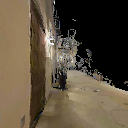

In [21]:
Image.fromarray(data['obs'][1]['rgb'])

In [33]:
from utils.visualizations import combine_all_audio_data

In [40]:
data['sound_id']

['val/chair/0102S12.2.wav']

In [41]:
combine_all_audio_data(data , output_path='1.wav')

开始处理 13 个音频片段...
片段 0: 有声音 (最大值: 1.95e-03)
片段 1: 有声音 (最大值: 1.63e-03)
片段 2: 有声音 (最大值: 1.97e-03)
片段 3: 有声音 (最大值: 5.00e-03)
片段 4: 有声音 (最大值: 8.13e-03)
片段 5: 有声音 (最大值: 1.07e-02)
片段 6: 有声音 (最大值: 1.73e-02)
片段 7: 有声音 (最大值: 2.32e-02)
片段 8: 有声音 (最大值: 1.90e-02)
片段 9: 有声音 (最大值: 1.15e-02)
片段 10: 有声音 (最大值: 2.51e-02)
片段 11: 有声音 (最大值: 1.31e-01)
片段 12: 有声音 (最大值: 1.31e-01)
正在合并音频片段...
✅ 所有音频已合并保存至：1.wav
合并后音频形状：(208000, 2)
总时长：13.00 秒
